In [3]:
#IMPORT all Packages we need for this feature.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy import ndimage
from ripser import ripser, lower_star_img
from persim import plot_diagrams 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle
from joblib import dump, load

In [4]:
#Functions
def get_image(url):
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_image(image):
    plt.figure(figsize=(15,8))
    b,g,r = cv2.split(image)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb

    plt.imshow(rgb_img)
    plt.xticks([]); plt.yticks([])   # to hide tick values on X and Y axis

def preprocess_image_gray(image):
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = ndimage.uniform_filter(image.astype(np.float64), size=5)
    image += 0.01 * np.random.randn(*image.shape)  
    return image

def get_patches(img,patch_size=(200,200),get_rects=True):
    image=img.copy()
    N=image.shape[0]; M=image.shape[1]
    x_size=y_size=int(min(N,M)/5)
    Patches=[image[y:(y+y_size),x:(x+x_size)].copy() for x in [0,M-x_size] for y in [0,N-y_size]]

    #Choose one random in the middle
    x=np.random.randint(x_size,M-2*x_size)
    y=np.random.randint(y_size,N-2*y_size)

    Patches.append(image[y:(y+y_size),x:(x+x_size)].copy())
    image[y:(y+y_size),x:(x+x_size)]=0
    
    #Resize the Patches
    Patches=[cv2.resize(img,patch_size) for img in Patches]
    
    if get_rects:
        Rects=[[x,y]]
        Rects+=[[x,y] for x in [0,M-x_size] for y in [0,N-y_size]]
        return Patches,Rects,(x_size,y_size)
        
    return Patches



In [17]:
#Counting Brush Strokes Using lower_star persistence
def count_brush_strokes(url,thresh=10,plot=True):
    #Read Image
    image=get_image(url)
    
    #Plot original image?    
    if plot:
        plt.figure(figsize=(15,10))
        plot_image(image)
        plt.title('Original')

    #PreProcess
    image=preprocess_image_gray(image)
    
    if plot:
        fig,ax0 = plt.subplots(1,figsize=(15,10))
        ax0.imshow(image,cmap='gray')
        ax0.set_title('Gray Smoothed')
        
    #Get Patches
    Patches,Rects, (w,h)=get_patches(image)
    
    #Prepare to plot the Patches
    if plot:
        for rect in Rects:
            ax0.add_patch(Rectangle(rect,w,h,linewidth=10,edgecolor='g',facecolor='none'))
        fig,axes=plt.subplots(2,3,figsize=(15,10))
        axes=axes.ravel()
        plt.title('')   
    
    #Compute and plot the Persistance Diagrams
    Dgms=[]
    No_Strokes=[]
    for i in range(5):
        patch=Patches[i]
        
        #Find the lower_star persistence using ripser
        #Cite Tom Needham
        dgm = lower_star_img(-patch)
        Dgms.append(dgm)
        
        #Get the indices of the persistence classes with life > thresh
        idxs = np.arange(dgm.shape[0])
        idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]
        
        #Plot
        if plot:
            ax=axes[i]
            ax.imshow(patch,cmap='gray')
        
        #Create a meshgrid
        X, Y = np.meshgrid(np.arange(patch.shape[1]), np.arange(patch.shape[0]))
        X = X.flatten()
        Y = Y.flatten()
        
        #Translate back the persistence classes into points of the original image.
        bidxs=[]
        for idx in idxs:
            bidx = np.argmin(np.abs(patch + dgm[idx, 0]))
            if plot:
                ax.scatter(X[bidx], Y[bidx], 25, 'r')
            bidxs.append(bidx)
        bidxs=list(set(bidxs))
        No_Strokes.append(len(bidxs))
        if plot:
            ax.set_title('Strokes: '+str(len(bidxs)))
        
    #Return the min, max and mean no. of Brush Strokes
    return [np.min(No_Strokes),np.max(No_Strokes),np.mean(No_Strokes)]

In [18]:
#Function to compute this an imported Catalog
def compute_no_strokes(Catalog0):
    Catalog=Catalog0.copy()
    N=Catalog.shape[0]
    No_Strokes_DF=pd.DataFrame(index=np.arange(0, N),columns=['Min_Strokes','Max_Strokes','Mean_Strokes']) 
    for ind in Catalog.index:
        url=Catalog.URL[ind]
        strokes=count_brush_strokes(url,10,False)
        No_Strokes_DF.loc[ind]=strokes
    Catalog=pd.concat([Catalog,No_Strokes_DF],axis=1)
    return Catalog

[74, 109, 91.4]

<Figure size 1080x720 with 0 Axes>

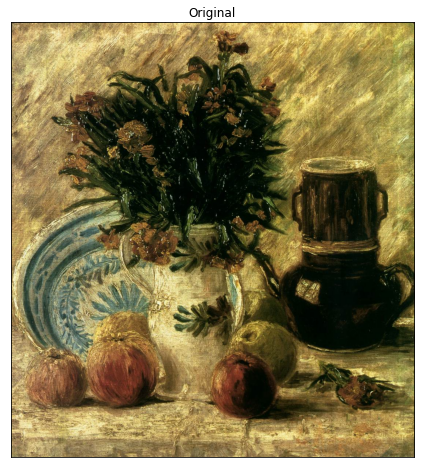

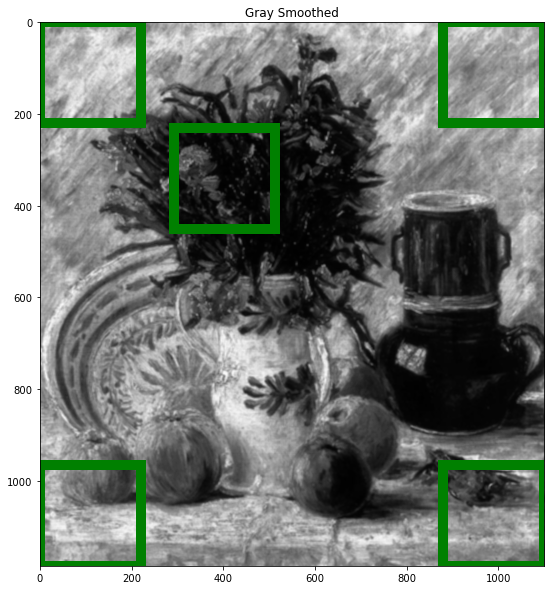

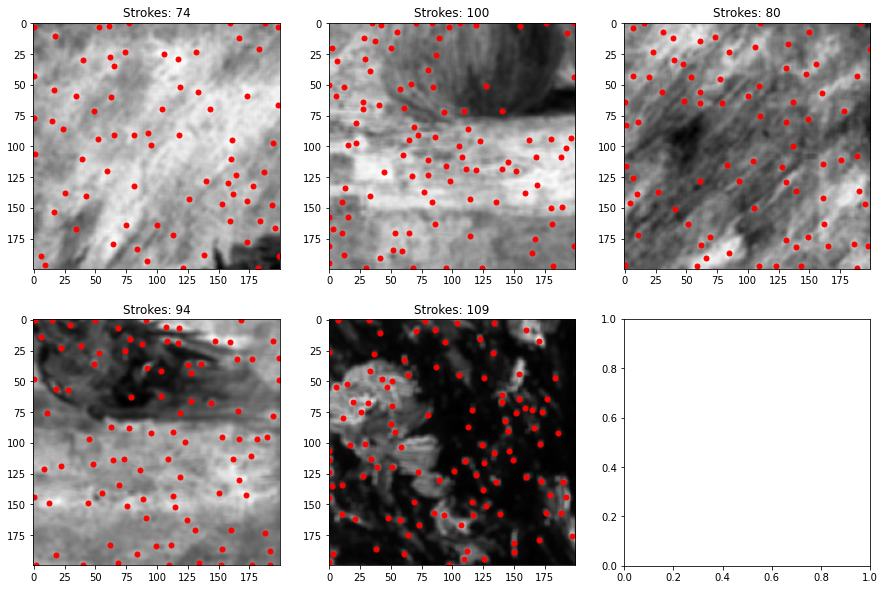

In [19]:
#We plot some nice examples just to illustrate what we are doing. 
url='https://www.wga.hu/art/g/gogh_van/05/flower09.jpg'
count_brush_strokes(url)

[11, 29, 19.4]

<Figure size 1080x720 with 0 Axes>

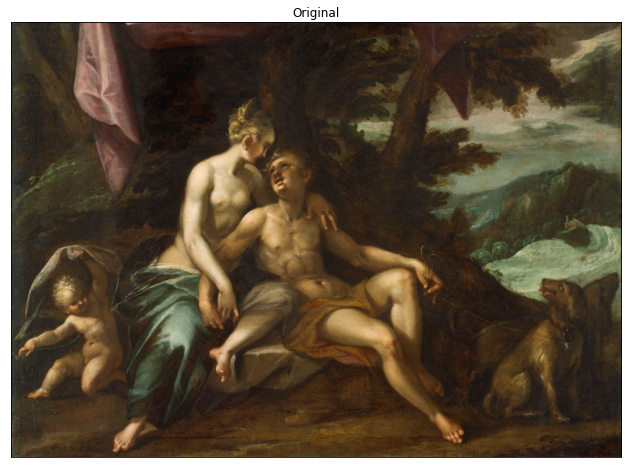

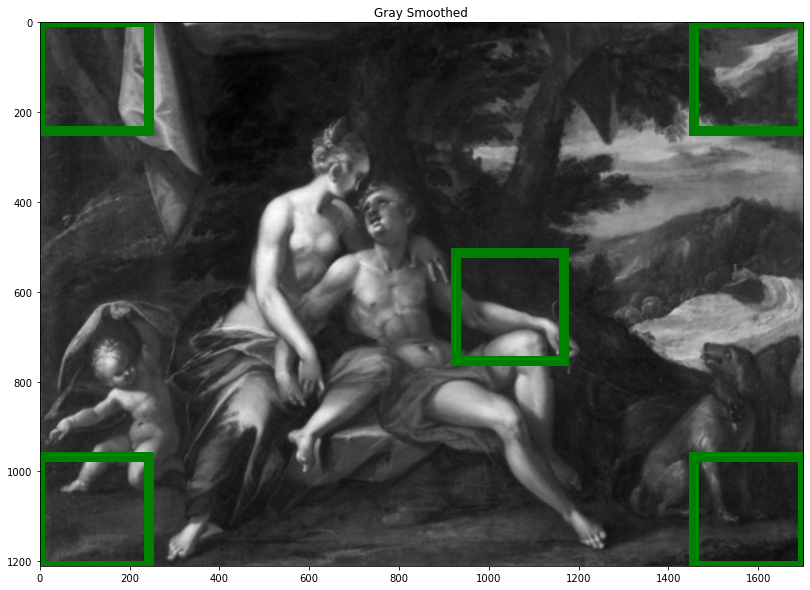

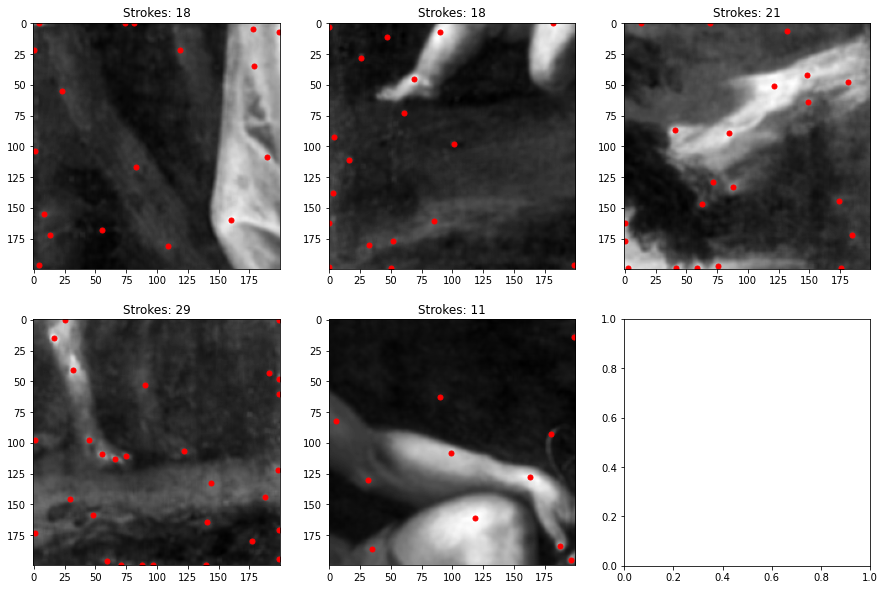

In [20]:
url='https://www.wga.hu/art/a/aachen/adonis.jpg'
count_brush_strokes(url)

In [22]:
#Now We'll proceed to compute all this numbers for our data_bases
#Only run once
#Catalog_train=pd.read_pickle('Catalog_train.pkl')
#Catalog_train=Catalog_train.reset_index(drop=True)
#Catalog_train=compute_no_strokes(Catalog_train)
#pd.to_pickle(Catalog_train,'Catalog_train_with_strokes.pkl',protocol=3)

#Run the remaining times
#Catalog_train=pd.read_pickle('Catalog_train_with_strokes.pkl')

#Keep only what we'll need for train the model
X_train=Catalog_train[['Min_Strokes','Max_Strokes','Mean_Strokes']]
y_train=Catalog_train.Vangogh
del Catalog_train

NameError: name 'Catalog_train' is not defined

In [8]:
#Only run once
#Catalog_test=pd.read_pickle('Catalog_test.pkl')
#Catalog_test=Catalog_test.reset_index(drop=True)
#Catalog_test=compute_no_strokes(Catalog_test)
#pd.to_pickle(Catalog_test,'Catalog_test_with_strokes.pkl',protocol=3)

#Run the remaining times
Catalog_test=pd.read_pickle('Catalog_test_with_strokes.pkl')

#Keep only what we'll need for train the model
X_test=Catalog_test[['Min_Strokes','Max_Strokes','Mean_Strokes']]
y_test=Catalog_test.Vangogh
del Catalog_test

In [11]:
tree_cl=DecisionTreeClassifier(max_depth=1)
tree_cl.fit(X_train,y_train)
print('Score on train data: {:.2%}'.format(tree_cl.score(X_train,y_train)))

#Confusion Matrix
print('\nConfusion Matrix on train data')
y_pred=tree_cl.predict(X_train)
M=confusion_matrix(y_pred,y_train,normalize='all')
M=pd.DataFrame(M,columns=['True Other','True Van Gogh'],index=['Pred. Other','Pred. Van Gog'])
display(M.style.format('{:.2%}'))

#For the test data we compute the score, but don't understand it further, as to only use train data for this feature.
print('Score on test data: {:.2%}'.format(tree_cl.score(X_test,y_test)))

Score on train data: 82.92%

Confusion Matrix on train data


,True Other,True Van Gogh
Pred. Other,66.51%,8.11%
Pred. Van Gog,8.96%,16.42%


Score on test data: 81.89%


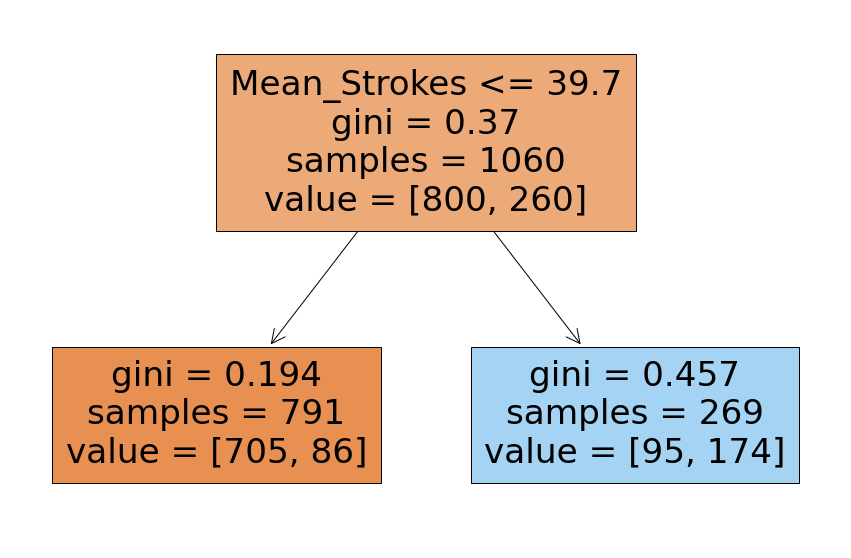

['Fitted_Models/Decision_Tree_No_Strokes.joblib']

In [12]:
#Finally we save the tree model we computed. 
plt.figure(figsize=(15,10))
tree.plot_tree(tree_cl,filled = True,feature_names=['Min_Strokes','Max_Strokes','Mean_Strokes'])
plt.show()

dump(tree_cl, 'Fitted_Models/Decision_Tree_No_Strokes.joblib') 
#To Load the model
#tree_cl = load('Fitted_Models/Decision_Tree_No_Strokes.joblib') 